In [1]:
# Set up Dependencies
from progress.bar import IncrementalBar
import matplotlib.pyplot as plt
import statistics as st
import pandas as pd
import numpy as np
import requests
import time
import nltk
import json
import csv
import sys
import os
from scipy.stats import linregress
from pprint import pprint

In [2]:
limit=1500

In [3]:
# read the data back into the dataframe from the csv file
input_data_file = os.path.join('data_files','good_merged_data.csv')

# write the DataFrame data to the csv file
movie_df = pd.read_csv(input_data_file)

movie_df.head()

,Title,Year,Rated,Released,Runtime,Genre,Language,Awards,imdbRating,imdbVotes,imdbID,Type,Production,Budget,Revenue,ROI%
0,Vulgar,2000,R,26 Apr 2002,87,"Crime, Drama, Thriller",English,NaN,5.3,3876,tt0120467,movie,Lions Gate Films,120000,14904,-87.58
1,Out of the Furnace,2013,R,06 Dec 2013,116,"Action, Crime, Drama, Thriller",English,2 wins & 9 nominations.,6.8,103339,tt1206543,movie,Relativity Media,22000000,15400000,-30.00
2,Coyote Ugly,2000,PG-13,04 Aug 2000,100,"Comedy, Drama, Music, Romance",English,4 wins & 8 nominations.,5.7,104644,tt0200550,movie,Buena Vista,45000000,113916474,153.15
3,Parental Guidance,2012,PG,25 Dec 2012,105,"Comedy, Family",English,1 win & 4 nominations.,6.0,24453,tt1047540,movie,20th Century Fox,25000000,119772232,379.09
4,Raising Helen,2004,PG-13,28 May 2004,119,"Comedy, Drama, Romance",English,1 nomination.,6.0,34868,tt0350028,movie,Buena Vista Pictures,50000000,49718611,-0.56


In [4]:
genres = movie_df['Genre'].to_list()

In [5]:
genres_df = movie_df.copy()
genres_df.drop(columns=['Title','Year','Rated','Released','Runtime','Language','Awards',
                        'Type','Production','Budget'], inplace=True)
genres_df

,Genre,imdbRating,imdbVotes,imdbID,Revenue,ROI%
0,"Crime, Drama, Thriller",5.3,3876,tt0120467,14904,-87.58
1,"Action, Crime, Drama, Thriller",6.8,103339,tt1206543,15400000,-30.00
2,"Comedy, Drama, Music, Romance",5.7,104644,tt0200550,113916474,153.15
3,"Comedy, Family",6.0,24453,tt1047540,119772232,379.09
4,"Comedy, Drama, Romance",6.0,34868,tt0350028,49718611,-0.56
...,...,...,...,...,...,...
581,"Horror, Sci-Fi, Thriller",6.6,199775,tt5442430,100541806,73.35
582,"Comedy, Crime, Drama",7.1,98589,tt1450321,9114264,82.29
583,"Biography, Comedy, Crime",5.8,48784,tt2461150,29200000,16.80
584,"Animation, Adventure, Comedy, Family, Sci-Fi",6.0,49599,tt0762125,104945765,49.92


In [6]:
genre_list = []
for genre in genres:
    extract = genre.split(',')

    for item in extract:
        item = str(item).replace(' ','')
        if item not in genre_list:
            genre_list.append(item)

In [7]:
dictOfGenres = { i : {'ROI':[],'Revenue':[],'Rating':[],'Votes':[],'filt_ROI':[],'filt_Rating':[],'filt_Votes':[],'filt_Revenue':[],'filt_ROI_woOut':[]} for i in genre_list }
dictOfGenres

{'Crime': {'ROI': [],
  'Revenue': [],
  'Rating': [],
  'Votes': [],
  'filt_ROI': [],
  'filt_Rating': [],
  'filt_Votes': [],
  'filt_Revenue': [],
  'filt_ROI_woOut': []},
 'Drama': {'ROI': [],
  'Revenue': [],
  'Rating': [],
  'Votes': [],
  'filt_ROI': [],
  'filt_Rating': [],
  'filt_Votes': [],
  'filt_Revenue': [],
  'filt_ROI_woOut': []},
 'Thriller': {'ROI': [],
  'Revenue': [],
  'Rating': [],
  'Votes': [],
  'filt_ROI': [],
  'filt_Rating': [],
  'filt_Votes': [],
  'filt_Revenue': [],
  'filt_ROI_woOut': []},
 'Action': {'ROI': [],
  'Revenue': [],
  'Rating': [],
  'Votes': [],
  'filt_ROI': [],
  'filt_Rating': [],
  'filt_Votes': [],
  'filt_Revenue': [],
  'filt_ROI_woOut': []},
 'Comedy': {'ROI': [],
  'Revenue': [],
  'Rating': [],
  'Votes': [],
  'filt_ROI': [],
  'filt_Rating': [],
  'filt_Votes': [],
  'filt_Revenue': [],
  'filt_ROI_woOut': []},
 'Music': {'ROI': [],
  'Revenue': [],
  'Rating': [],
  'Votes': [],
  'filt_ROI': [],
  'filt_Rating': [],
  'fil

In [8]:
for col in genre_list:
    genres_df[col] = ''

genres_df

,Genre,imdbRating,imdbVotes,imdbID,Revenue,ROI%,Crime,Drama,Thriller,Action,...,History,Fantasy,Biography,Horror,Mystery,Musical,Animation,Western,War,Documentary
0,"Crime, Drama, Thriller",5.3,3876,tt0120467,14904,-87.58,,,,,...,,,,,,,,,,
1,"Action, Crime, Drama, Thriller",6.8,103339,tt1206543,15400000,-30.00,,,,,...,,,,,,,,,,
2,"Comedy, Drama, Music, Romance",5.7,104644,tt0200550,113916474,153.15,,,,,...,,,,,,,,,,
3,"Comedy, Family",6.0,24453,tt1047540,119772232,379.09,,,,,...,,,,,,,,,,
4,"Comedy, Drama, Romance",6.0,34868,tt0350028,49718611,-0.56,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,"Horror, Sci-Fi, Thriller",6.6,199775,tt5442430,100541806,73.35,,,,,...,,,,,,,,,,
582,"Comedy, Crime, Drama",7.1,98589,tt1450321,9114264,82.29,,,,,...,,,,,,,,,,
583,"Biography, Comedy, Crime",5.8,48784,tt2461150,29200000,16.80,,,,,...,,,,,,,,,,
584,"Animation, Adventure, Comedy, Family, Sci-Fi",6.0,49599,tt0762125,104945765,49.92,,,,,...,,,,,,,,,,


In [9]:
for index, row in genres_df.iterrows():
#     print(row['Genre'])
    extract = row['Genre'].split(', ')

    for key in dictOfGenres:
        if key in extract:
            dictOfGenres[key]['ROI'].append(row['ROI%'])
            dictOfGenres[key]['Rating'].append(row['imdbRating'])
            dictOfGenres[key]['Votes'].append(row['imdbVotes'])
            dictOfGenres[key]['Revenue'].append(row['Revenue'])            
            dictOfGenres[key]['filt_ROI'].append(row['ROI%'])
            dictOfGenres[key]['filt_Rating'].append(row['imdbRating'])
            dictOfGenres[key]['filt_Votes'].append(row['imdbVotes'])
            dictOfGenres[key]['filt_Revenue'].append(row['Revenue'])
            if row['ROI%'] < limit:
                dictOfGenres[key]['filt_ROI_woOut'].append(row['ROI%'])
        else:
            dictOfGenres[key]['ROI'].append(np.nan)
            dictOfGenres[key]['Rating'].append(np.nan)
            dictOfGenres[key]['Votes'].append(np.nan)
            dictOfGenres[key]['Revenue'].append(np.nan)
dictOfGenres

{'Crime': {'ROI': [-87.58,
   -30.0,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   121.11,
   nan,
   nan,
   276.4,
   nan,
   nan,
   nan,
   248.05,
   nan,
   nan,
   207.31,
   nan,
   nan,
   -46.51,
   nan,
   nan,
   nan,
   245.65,
   183.51,
   nan,
   nan,
   30.0,
   nan,
   nan,
   nan,
   nan,
   nan,
   21.96,
   nan,
   227.85,
   420.86,
   -31.23,
   nan,
   nan,
   67.03,
   nan,
   nan,
   nan,
   nan,
   nan,
   460.29,
   nan,
   -49.61,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   167.02,
   nan,
   nan,
   nan,
   16.11,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   -0.37,
   nan,
   nan,
   -65.28,
   nan,
   42.69,
   nan,
   -12.33,
   191.74,
   nan,
   153.27,
   nan,
   nan,
   nan,
   -80.4,
   276.47,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   113.4,
   nan,
   nan,
   nan,
   nan,
   nan,

In [10]:
height = []
wedge = []
rating = []
votes = []
for key in dictOfGenres:
    genres_df[key] = dictOfGenres[key]['Revenue']
    height.append(genres_df[key].mean())
    wedge.append(genres_df[key].count())
    genres_df[key] = dictOfGenres[key]['Rating']
    rating.append(genres_df[key].mean())
    genres_df[key] = dictOfGenres[key]['Votes']
    votes.append(genres_df[key].mean())

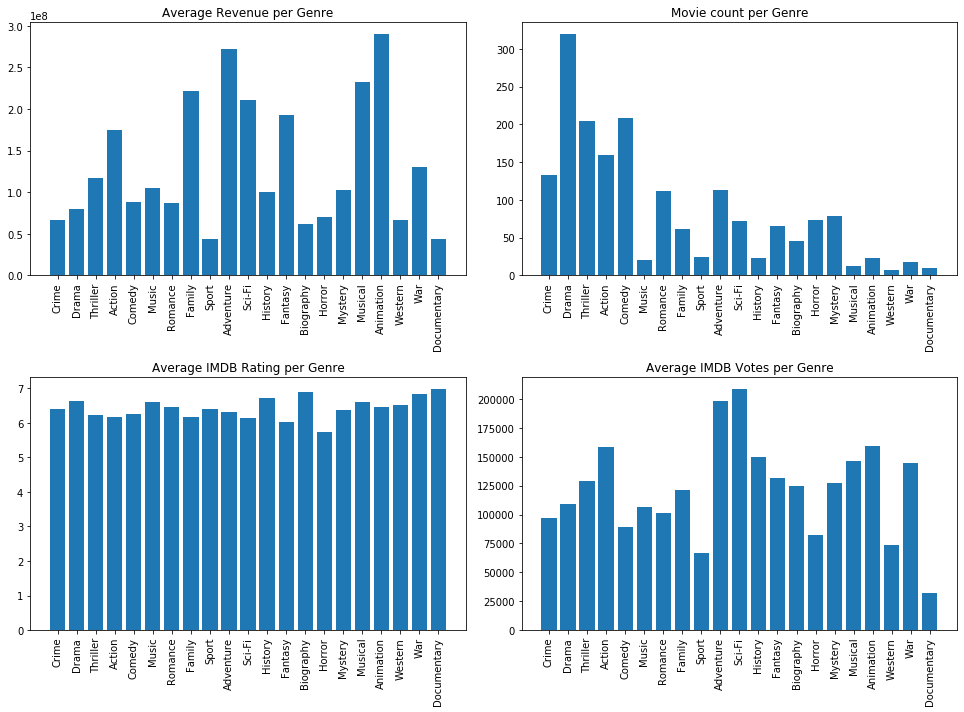

In [15]:
y_pos = np.arange(len(genre_list))
fig = plt.figure(figsize=[20, 10])
gs = plt.GridSpec(2, 3, figure=fig)

# Create bars
ax1 = fig.add_subplot(gs[0, 1])
ax1.bar(y_pos, height) 
# Create names on the x-axis
ax1.set_xticks(y_pos)
ax1.set_xticklabels(genre_list, rotation='vertical')
ax1.set_title('Average Revenue per Genre')

# Create bars
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(y_pos, wedge)
# Create names on the x-axis
ax2.set_xticks(y_pos)
ax2.set_xticklabels(genre_list, rotation='vertical')
ax2.set_title('Movie count per Genre')

# Create bars
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(y_pos, rating)
# Create names on the x-axis
ax3.set_xticks(y_pos)
ax3.set_xticklabels(genre_list, rotation='vertical')
ax3.set_title('Average IMDB Rating per Genre')

# Create bars
ax4 = fig.add_subplot(gs[1, 2])
ax4.bar(y_pos, votes)
# Create names on the x-axis
ax4.set_xticks(y_pos)
ax4.set_xticklabels(genre_list, rotation='vertical')
ax4.set_title('Average IMDB Votes per Genre')

fig.tight_layout()
# Show graphic
plt.show()


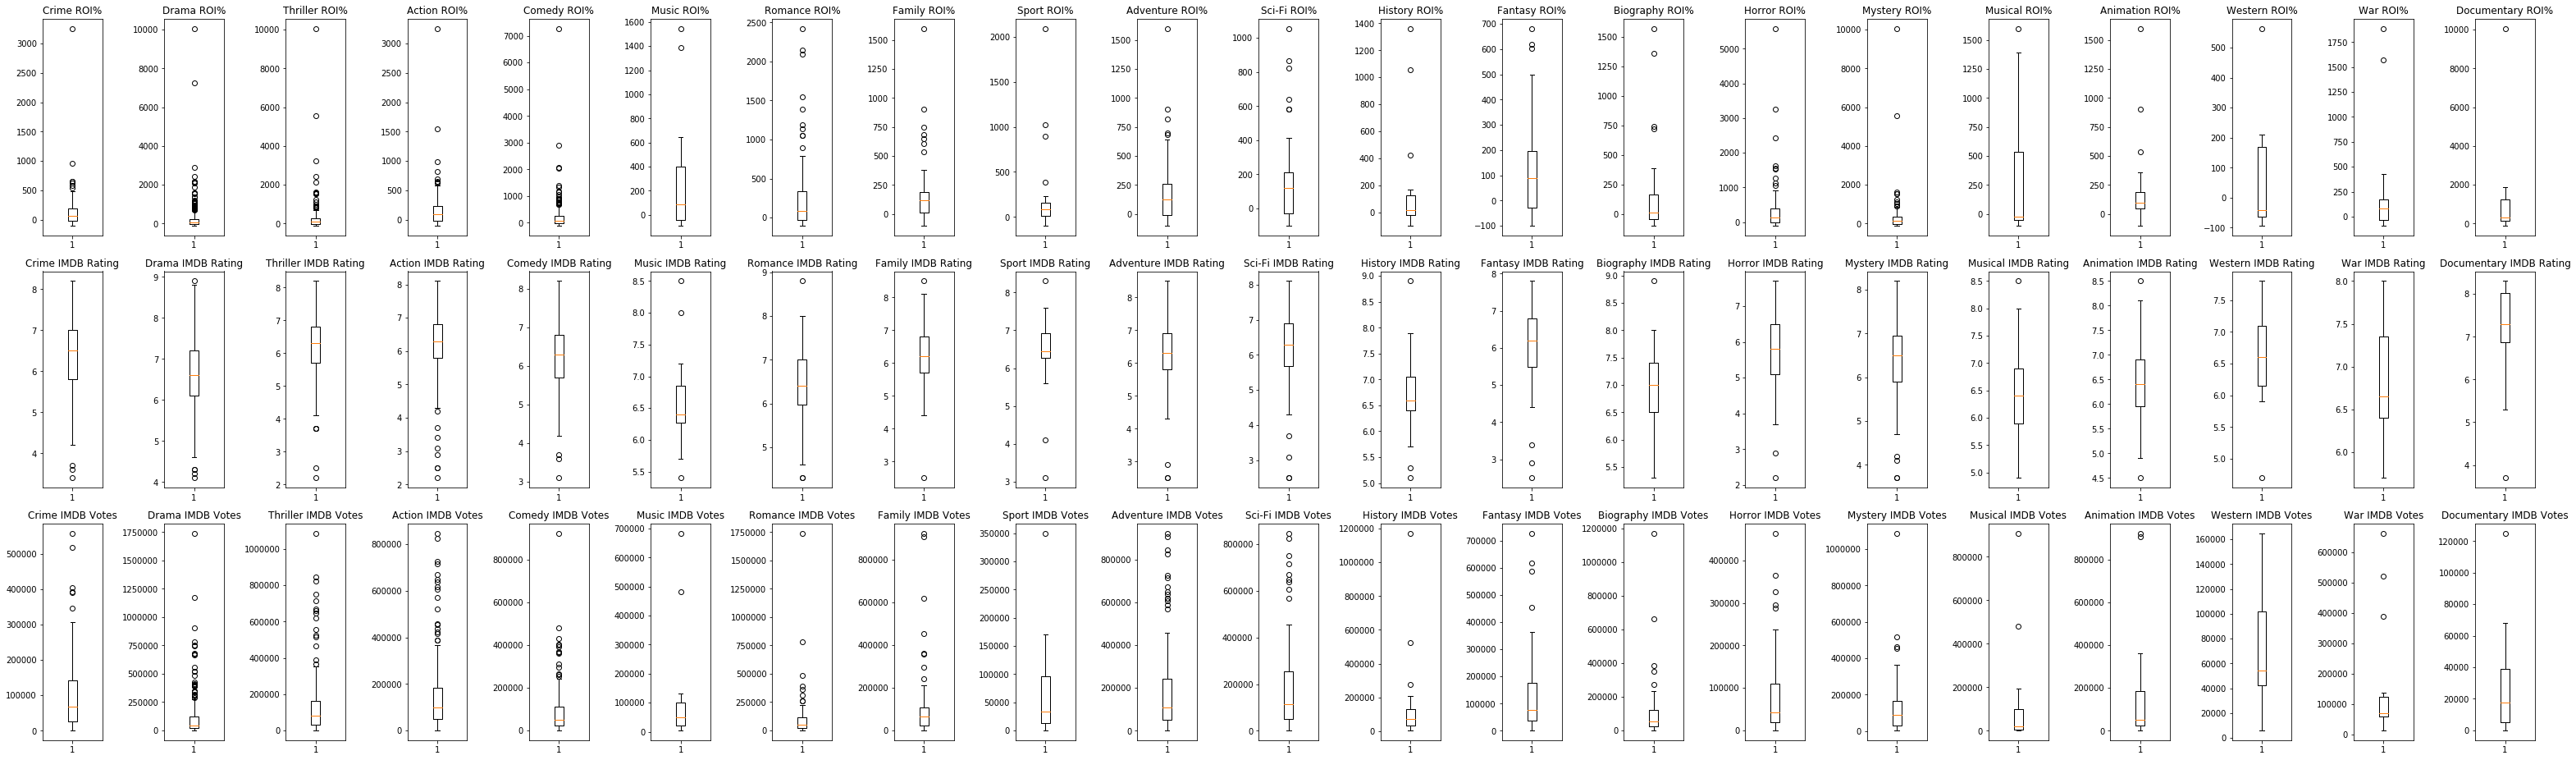

In [12]:
fig = plt.figure(figsize=[45, 17])
gs = plt.GridSpec(4, 22, figure=fig)

r = 1
for key in dictOfGenres:
    ax1 = fig.add_subplot(gs[0, r])
    ax1.boxplot(dictOfGenres[key]['filt_ROI'])
    ax1.set_title(f'{key} ROI%')

    ax2 = fig.add_subplot(gs[1, r])
    ax2.boxplot(dictOfGenres[key]['filt_Rating'])
    ax2.set_title(f'{key} IMDB Rating')

    ax3 = fig.add_subplot(gs[2, r])
    ax3.boxplot(dictOfGenres[key]['filt_Votes'])
    ax3.set_title(f'{key} IMDB Votes')
    
    r+=1

fig.tight_layout()
box_fig_path = os.path.join('figures','Genre_all_separate_plots.png')
fig.savefig(box_fig_path)
# Show graphic
plt.show()

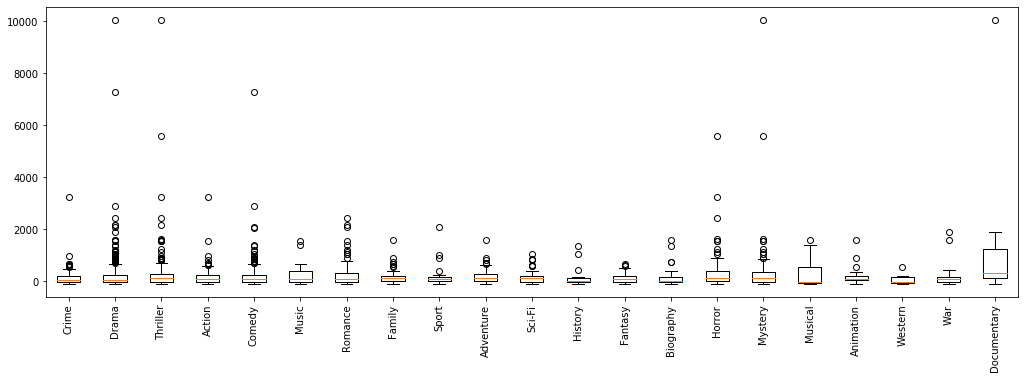

In [13]:
fig = plt.figure(figsize=[28, 20])
gs = plt.GridSpec(4, 2, figure=fig)

r = 1
# for key in dictOfGenres:
ax1 = fig.add_subplot(gs[0, r])
ax1.boxplot([dictOfGenres['Crime']['filt_ROI'],dictOfGenres['Drama']['filt_ROI'],dictOfGenres['Thriller']['filt_ROI'],
            dictOfGenres['Action']['filt_ROI'],dictOfGenres['Comedy']['filt_ROI'],dictOfGenres['Music']['filt_ROI'],
            dictOfGenres['Romance']['filt_ROI'],dictOfGenres['Family']['filt_ROI'],dictOfGenres['Sport']['filt_ROI'],
            dictOfGenres['Adventure']['filt_ROI'],dictOfGenres['Sci-Fi']['filt_ROI'],dictOfGenres['History']['filt_ROI'],
            dictOfGenres['Fantasy']['filt_ROI'],dictOfGenres['Biography']['filt_ROI'],dictOfGenres['Horror']['filt_ROI'],
            dictOfGenres['Mystery']['filt_ROI'],dictOfGenres['Musical']['filt_ROI'],dictOfGenres['Animation']['filt_ROI'],
            dictOfGenres['Western']['filt_ROI'],dictOfGenres['War']['filt_ROI'],dictOfGenres['Documentary']['filt_ROI']])
ax1.set_xticklabels(genre_list, rotation='vertical')
#     ax1.set_title(f'{key} ROI%')

#     ax2 = fig.add_subplot(gs[1, r])
#     ax2.boxplot(dictOfGenres[key]['filt_Rating'])
#     ax2.set_title(f'{key} IMDB Rating')

#     ax3 = fig.add_subplot(gs[2, r])
#     ax3.boxplot(dictOfGenres[key]['filt_Votes'])
#     ax3.set_title(f'{key} IMDB Votes')
    
#     r+=1

fig.tight_layout()
box_fig_path = os.path.join('figures','Genre_ROI_all_together.png')
fig.savefig(box_fig_path)
# Show graphic
plt.show()

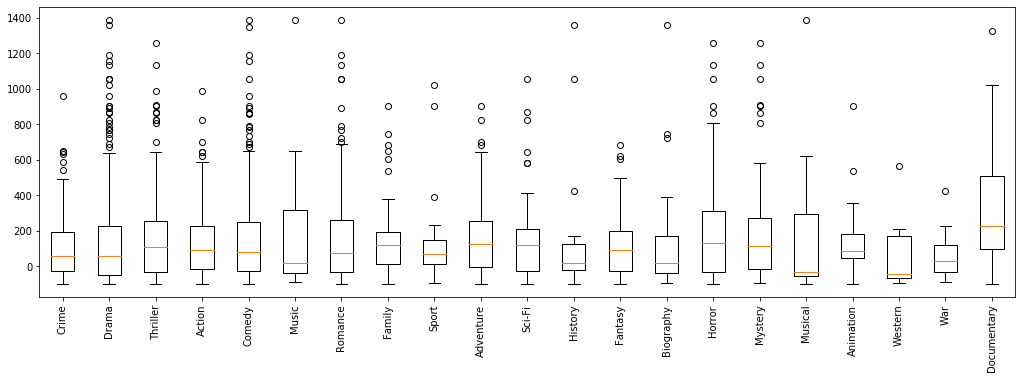

In [14]:
fig = plt.figure(figsize=[28, 20])
gs = plt.GridSpec(4, 2, figure=fig)

r = 1
# for key in dictOfGenres:
ax1 = fig.add_subplot(gs[0, r])
ax1.boxplot([dictOfGenres['Crime']['filt_ROI_woOut'],dictOfGenres['Drama']['filt_ROI_woOut'],dictOfGenres['Thriller']['filt_ROI_woOut'],
            dictOfGenres['Action']['filt_ROI_woOut'],dictOfGenres['Comedy']['filt_ROI_woOut'],dictOfGenres['Music']['filt_ROI_woOut'],
            dictOfGenres['Romance']['filt_ROI_woOut'],dictOfGenres['Family']['filt_ROI_woOut'],dictOfGenres['Sport']['filt_ROI_woOut'],
            dictOfGenres['Adventure']['filt_ROI_woOut'],dictOfGenres['Sci-Fi']['filt_ROI_woOut'],dictOfGenres['History']['filt_ROI_woOut'],
            dictOfGenres['Fantasy']['filt_ROI_woOut'],dictOfGenres['Biography']['filt_ROI_woOut'],dictOfGenres['Horror']['filt_ROI_woOut'],
            dictOfGenres['Mystery']['filt_ROI_woOut'],dictOfGenres['Musical']['filt_ROI_woOut'],dictOfGenres['Animation']['filt_ROI_woOut'],
            dictOfGenres['Western']['filt_ROI_woOut'],dictOfGenres['War']['filt_ROI_woOut'],dictOfGenres['Documentary']['filt_ROI_woOut']])
ax1.set_xticklabels(genre_list, rotation='vertical')
fig.tight_layout()
box_fig_path = os.path.join('figures',f'full_figure_ROI_under{limit}.png')
fig.savefig(box_fig_path)
# Show graphic
plt.show()